In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='Your specific warning message')

import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pandas_profiling import ProfileReport

# DATA INFO

In [2]:
df = pd.read_excel('network_traffic.csv.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            3000 non-null   float64
 1   protocol_type       3000 non-null   object 
 2   service             3000 non-null   object 
 3   flag                3000 non-null   object 
 4   src_bytes           3000 non-null   float64
 5   dst_bytes           3000 non-null   float64
 6   land                3000 non-null   float64
 7   wrong_fragment      3000 non-null   float64
 8   urgent              3000 non-null   float64
 9   hot                 3000 non-null   float64
 10  num_failed_logins   3000 non-null   float64
 11  logged_in           3000 non-null   float64
 12  num_compromised     3000 non-null   float64
 13  root_shell          3000 non-null   float64
 14  su_attempted        3000 non-null   float64
 15  num_root            3000 non-null   float64
 16  num_fi

In [4]:
df.head(5)

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0       NaN           NaN     NaN  NaN        NaN        NaN   NaN   
1       0.0           tcp    http   SF      302.0      896.0   0.0   
2       0.0           tcp    http   SF      339.0     1588.0   0.0   
3       0.0           tcp    http   SF      260.0     7334.0   0.0   
4       0.0           tcp    http   SF      213.0     8679.0   0.0   

   wrong_fragment  urgent  hot  ...  root_shell  su_attempted  num_root  \
0             NaN     NaN  NaN  ...         NaN           NaN       NaN   
1             0.0     0.0  0.0  ...         0.0           0.0       0.0   
2             0.0     0.0  0.0  ...         0.0           0.0       0.0   
3             0.0     0.0  0.0  ...         0.0           0.0       0.0   
4             0.0     0.0  0.0  ...         0.0           0.0       0.0   

   num_file_creations  num_shells  num_access_files  num_outbound_cmds  \
0                 NaN         NaN               NaN                NaN   
1                 0.0         0.0               0.0                0.0   
2                 0.0         0.0               0.0                0.0   
3                 0.0         0.0               0.0                0.0   
4                 0.0         0.0               0.0                0.0   

   is_host_login  is_guest_login  is_intrusion  
0            NaN             NaN           NaN  
1            0.0             0.0             0  
2            0.0             0.0             0  
3            0.0             0.0             0  
4            0.0             0.0             0  

[5 rows x 23 columns]

# PROFILE TABLE USING PANDAS PROFILING

In [5]:
# Generate a profile report
profile = ProfileReport(df)

# Display the report in the Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# CUSTOM PROFILE TABLE

In [6]:
# Create a dictionary to map column names to their types
column_types = {
    "duration": "continuous",
    "protocol_type": "discrete",
    "service": "discrete",
    "src_bytes": "continuous",
    "dst_bytes": "continuous",
    "flag": "discrete",
    "land": "discrete",
    "wrong_fragment": "continuous",
    "urgent": "continuous",
    "hot": "continuous",
    "num_failed_logins": "continuous",
    "logged_in": "discrete",
    "num_compromised": "continuous",
    "root_shell": "discrete",
    "su_attempted": "discrete",
    "num_root": "continuous",
    "num_file_creations": "continuous",
    "num_shells": "continuous",
    "num_access_files": "continuous",
    "num_outbound_cmds": "continuous",
    "is_hot_login": "discrete",
    "is_guest_login": "discrete",
    "is_intrusion": "discrete"
}

# Initialize PrettyTables for numeric and discrete columns
numeric_table = PrettyTable()
numeric_table.field_names = ["Column", "Data Type", "Type Category", "Min", "Max", "Mean", "Median", "Std Dev", "Missing"]

discrete_table = PrettyTable()
discrete_table.field_names = ["Column", "Data Type", "Type Category", "Total Unique", "Top 3 Values", "Missing"]

numeric_column_count = 0
discrete_column_count = 0

# Iterate through each column in the DataFrame
for column in df.columns:
    column_info = {
        "Column": column,
        "Data Type": df[column].dtype,
        "Type Category": column_types.get(column, "unknown"),
    }

    # Check if it's numeric
    if column_info["Type Category"] == "continuous":
        numeric_column_count += 1
        # Calculate statistics for numeric attributes and round them to 2 decimal places
        column_info["Min"] = round(df[column].min(), 2)
        column_info["Max"] = round(df[column].max(), 2)
        column_info["Mean"] = round(df[column].mean(), 2)
        column_info["Median"] = round(df[column].median(), 2)
        column_info["Standard Deviation"] = round(df[column].std(), 2)
        
        numeric_table.add_row([column_info["Column"], column_info["Data Type"], column_info["Type Category"],
                               column_info.get("Min", ""), column_info.get("Max", ""),
                               column_info.get("Mean", ""), column_info.get("Median", ""),
                               column_info.get("Standard Deviation", ""), df[column].isna().sum()])
    else:
        discrete_column_count += 1
        # Calculate statistics for non-numeric (discrete/symbolic) attributes
        column_info["Total Unique Values"] = df[column].nunique()
        top_values = df[column].value_counts().head(3)
        top_3_values = "\n".join([f"{val}: {count}" for val, count in top_values.items()])
        
        discrete_table.add_row([column_info["Column"], column_info["Data Type"], column_info["Type Category"],
                                column_info.get("Total Unique Values", ""), top_3_values, df[column].isna().sum()])

# Define the heading
profile_table_heading = "Profile Tables"

# Print the heading
print(profile_table_heading)
print("\n")

# Print the numeric table with the total number of numeric columns
print(f"Numeric Columns (Total Numeric Columns: {numeric_column_count}):")
print(numeric_table)
print("\n")

# Print the discrete table with the total number of discrete columns
print(f"Discrete Columns (Total Discrete Columns: {discrete_column_count}):")
print(discrete_table)


Profile Tables


Numeric Columns (Total Numeric Columns: 13):
+--------------------+-----------+---------------+-----+----------+---------+--------+----------+---------+
|       Column       | Data Type | Type Category | Min |   Max    |   Mean  | Median | Std Dev  | Missing |
+--------------------+-----------+---------------+-----+----------+---------+--------+----------+---------+
|      duration      |  float64  |   continuous  | 0.0 | 24204.0  |  118.08 |  0.0   |  964.54  |    1    |
|     src_bytes      |  float64  |   continuous  | 0.0 | 283618.0 | 4567.78 | 228.0  | 29461.82 |    1    |
|     dst_bytes      |  float64  |   continuous  | 0.0 | 273544.0 |  2705.4 | 388.5  | 9988.33  |    1    |
|   wrong_fragment   |  float64  |   continuous  | 0.0 |   0.0    |   0.0   |  0.0   |   0.0    |    1    |
|       urgent       |  float64  |   continuous  | 0.0 |   0.0    |   0.0   |  0.0   |   0.0    |    1    |
|        hot         |  float64  |   continuous  | 0.0 |   25.0   |   0.07

# DATA PREPROCESSING

In [7]:
# Drop rows with missing values
df = df.dropna()

# Display the cleaned DataFrame
print(df)

      duration protocol_type service flag  src_bytes  dst_bytes  land  \
1          0.0           tcp    http   SF      302.0      896.0   0.0   
2          0.0           tcp    http   SF      339.0     1588.0   0.0   
3          0.0           tcp    http   SF      260.0     7334.0   0.0   
4          0.0           tcp    http   SF      213.0     8679.0   0.0   
5          0.0           tcp    http   SF      308.0     1658.0   0.0   
...        ...           ...     ...  ...        ...        ...   ...   
2996       0.0           tcp    http   SF      206.0      189.0   0.0   
2997       0.0           tcp    http   SF      318.0     6924.0   0.0   
2998       0.0           tcp    http   SF      333.0      774.0   0.0   
2999       0.0           tcp    http   SF      215.0      480.0   0.0   
3000       0.0           tcp    http   SF      241.0     5005.0   0.0   

      wrong_fragment  urgent  hot  ...  root_shell  su_attempted  num_root  \
1                0.0     0.0  0.0  ...       

As data as only 1 row of missing values so droped the row

count     3000
unique       3
top          0
freq      2699
Name: is_intrusion, dtype: int64


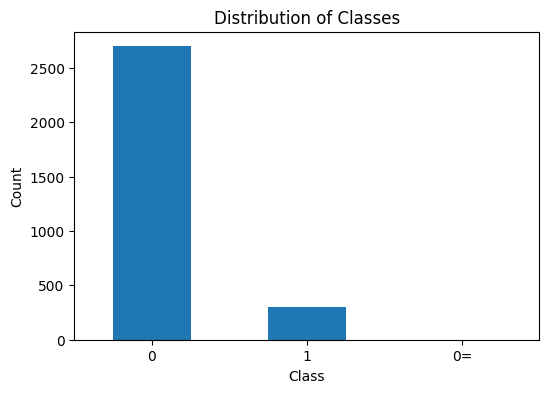

In [8]:
# Descriptive statistics for the "is_intrusion" column
intrusion_stats = df['is_intrusion'].describe()
# Print the summary statistics
print(intrusion_stats)

# Count the number of instances for each class
class_distribution = df['is_intrusion'].value_counts()

# Data visualization
plt.figure(figsize=(6, 4))
class_distribution.plot(kind='bar')
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

As we can see that the is_intrusion colum has 0,1 and 0=. 0= is only for a single row

In [9]:
# Identify unique values in the "is_intrusion" column
unique_values = df['is_intrusion'].unique()

# Print the unique values to understand the content
print("Unique values in 'is_intrusion' column:")
print(unique_values)

Unique values in 'is_intrusion' column:
[0 1 '0=']


In [10]:
# Preprocess the 'is_intrusion' column to remove '0=' and convert to numeric values
df['is_intrusion'] = df['is_intrusion'].apply(lambda x: 1 if str(x) == '1' else 0)

# Verify the unique values in the 'is_intrusion' column after preprocessing
unique_values = df['is_intrusion'].unique()
print("Unique values in 'is_intrusion' column:", unique_values)

Unique values in 'is_intrusion' column: [0 1]


In [54]:
import plotly.express as px

# Assuming 'class_distribution' is a pandas Series with class labels as index and counts as values
fig = px.bar(x=class_distribution.index, y=class_distribution.values,
             labels={'x': 'number of intrusions', 'y': 'Is intruiosn or not'},
             title="Distribution of Intrusion")

fig.update_xaxes(tickangle=0)

fig.show()


# ZERO ATTRIBUTES AND ITS CO-RELATION

land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'num_outbound_cmds' These atributes have a constant zero troughout the data so finding the corelation of zero attributes with all the remaning atributes to establish a relation and updating the attributes to a dataframe

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is your DataFrame
# Define the list of zero attributes to be analyzed
zero_attributes = ['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'num_outbound_cmds']

# Create an empty DataFrame to store the correlation results
correlation_results = pd.DataFrame(columns=['Attribute', 'Correlation'])

# Calculate the correlations between zero attributes and all other attributes
for attribute in zero_attributes:
    for column in df.columns:
        if column != attribute:
            if df[attribute].dtype != 'object' and df[column].dtype != 'object':
                # Handle missing or infinite values
                numeric_data = df[[attribute, column]].replace([np.inf, -np.inf], np.nan).dropna()
                # Calculate the Point-Biserial Correlation coefficient for numeric attributes
                point_biserial_corr, p_value = stats.pointbiserialr(numeric_data[attribute], numeric_data[column])
                if not pd.isna(point_biserial_corr):
                    correlation_results = pd.concat([correlation_results, pd.DataFrame({'Attribute': [f"{attribute}_{column}"], 'Correlation': [point_biserial_corr]})], ignore_index=True)
            elif df[attribute].dtype == 'object' and df[column].dtype != 'object':
                # Handle missing or infinite values
                numeric_data = df[[attribute, column]].replace([np.inf, -np.inf], np.nan).dropna()
                # Calculate the Cramér's V correlation coefficient for object attributes with numeric attributes
                contingency_table = pd.crosstab(numeric_data[attribute], numeric_data[column])
                chi2, _, _, _ = stats.chi2_contingency(contingency_table)
                n = len(numeric_data)
                phi2 = chi2 / n
                correlation_coeff = np.sqrt(phi2)
                correlation_results = pd.concat([correlation_results, pd.DataFrame({'Attribute': [f"{attribute}_{column}"], 'Correlation': [correlation_coeff]})], ignore_index=True)

# Display the correlation results
print(correlation_results)

Empty DataFrame
Columns: [Attribute, Correlation]
Index: []


we can see that the zero attributes have no corelation as the dataframe is empty

In [13]:
nan_values = df.isna().sum()

# Display the columns with NaN values and their counts
print("Columns with NaN values:")
print(nan_values[nan_values > 0])

Columns with NaN values:
Series([], dtype: int64)


In [14]:
# Drop rows with NaN values in-place
df.dropna(inplace=True)

as we can see that there is no corelation with the zero attributes dropping them would be a wise choice

In [15]:
zero_attributes = ['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'num_outbound_cmds']

# Drop the specified columns
df = df.drop(zero_attributes, axis=1)

In [16]:
import pandas as pd

# Assuming df is your DataFrame
unique_protocol_types = df['protocol_type'].unique()
unique_services = df['service'].unique()
unique_flags = df['flag'].unique()

print("Unique Protocol Types:", unique_protocol_types)
print("Unique Services:", unique_services)
print("Unique Flags:", unique_flags)

Unique Protocol Types: ['tcp' 'udp' 'icmp']
Unique Services: ['http' 'private' 'smtp' 'domain_u' 'ftp' 'ftp_data' 'ntp_u' 'other'
 'eco_i' 'urp_i' 'telnet' 'finger' 'ecr_i' 'pop_3' 'auth' 'time']
Unique Flags: ['SF' 'REJ' 'S0' 'RSTR' 'S3' 'RSTO']


In [17]:
import pandas as pd

# Assuming df is your cleaned DataFrame
df.to_csv('cleaned.csv', index=False)


In [18]:
import pandas as pd
import plotly.graph_objects as go

# Count the number of intrusions by protocol type
intrusion_count = df[df['is_intrusion'] == 1].groupby('protocol_type').size().reset_index(name='intrusion_count')

# Create the original bar chart
fig1 = go.Figure(go.Bar(
    x=df['protocol_type'].unique(),
    y=df['protocol_type'].value_counts(),
    name='Total Count',
    marker_color='blue'
))

# Create the bar chart for intrusion count
fig2 = go.Figure(go.Bar(
    x=intrusion_count['protocol_type'],
    y=intrusion_count['intrusion_count'],
    name='Intrusion Count',
    marker_color='red'
))

# Create the subplot with two charts side by side
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['protocol_type'].unique(),
    y=df['protocol_type'].value_counts(),
    name='Total Count',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=intrusion_count['protocol_type'],
    y=intrusion_count['intrusion_count'],
    name='Intrusion Count',
    marker_color='red'
))

# Update the layout for the subplot
fig.update_layout(
    title='Comparison of Protocol Types and Intrusion Count',
    xaxis_title='Protocol Type',
    yaxis_title='Count',
    barmode='group',
    legend_title='Legend',
)

# Show the subplot
fig.show()


In [19]:
import plotly.express as px

# Assuming 'df' is your DataFrame with 'is_intrusion' and 'duration' columns

# Create a scatter plot
fig = px.scatter(df, x='duration', y='is_intrusion', 
                 title='Scatter Plot: Relationship between is_intrusion and duration',
                 labels={'duration': 'Duration', 'is_intrusion': 'Is Intrusion'},
                 template='plotly_white',  # Use a white template for better readability
                 color_discrete_sequence=['blue'],  # Customize the color
                )

# Add a legend
fig.update_traces(showlegend=False)

# Add annotations for clarity
fig.update_layout(annotations=[
    dict(
        x=500,  # X-coordinate for the annotation
        y=0.5,  # Y-coordinate for the annotation
        text='Low Duration',
        showarrow=False,
        font=dict(size=12, color='blue'),
    ),
    dict(
        x=4000,  # X-coordinate for the annotation
        y=0.5,  # Y-coordinate for the annotation
        text='High Duration',
        showarrow=False,
        font=dict(size=12, color='blue'),
    ),
])

# Customize axis titles
fig.update_xaxes(title_text='Duration (ms)', title_font=dict(size=14))
fig.update_yaxes(title_text='Is Intrusion', title_font=dict(size=14))

# Show the plot
fig.show()


In [20]:
# Scatter Plot of Source vs. Destination Bytes
px.scatter(df, x='src_bytes', y='dst_bytes', color='is_intrusion', title='Source vs. Destination Bytes by Intrusion Flag')


What is the distribution of protocol types among the intrusions detected, and which protocol is most vulnerable?

In [21]:
import plotly.express as px

# Assuming 'df' is your DataFrame with 'is_intrusion' and 'protocol_type' columns

# Filter the DataFrame to include only intrusions
intrusions_df = df[df['is_intrusion'] == 1]

# Calculate the count of each protocol type
protocol_count = intrusions_df['protocol_type'].value_counts().reset_index()
protocol_count.columns = ['protocol_type', 'count']

# Create a bar chart to show the distribution of protocol types among intrusions
fig = px.bar(protocol_count, x='protocol_type', y='count', title='Distribution of Protocol Types Among Intrusions',
             labels={'protocol_type': 'Protocol Type', 'count': 'Count'},
             color='protocol_type', color_discrete_sequence=px.colors.qualitative.Set1,
             text='count')  # Display the 'count' column as text on the bars

# Add a legend
fig.update_traces(showlegend=True)

# Customize axis titles and legend title
fig.update_xaxes(title_text='Protocol Type', title_font=dict(size=14))
fig.update_yaxes(title_text='Count', title_font=dict(size=14))
fig.update_layout(legend_title_text='Protocol Type')

# Show the plot
fig.show()


How does the service type correlate with the frequency of intrusions?

In [22]:
# Filter the DataFrame to include only intrusions
intrusions_df = df[df['is_intrusion'] == 1]

# Calculate the count of each service type among intrusions
service_count = intrusions_df['service'].value_counts().reset_index()
service_count.columns = ['service', 'count']

# Create a bar chart to show the distribution of service types among intrusions
fig = px.bar(service_count, x='service', y='count', title='Distribution of Service Types Among Intrusions',
             labels={'service': 'Service Type', 'count': 'Count'},
             color='service', color_discrete_sequence=px.colors.qualitative.Set2,
             text='count')  # Display the 'count' column as text on top of the bars

# Customize axis titles and legend title
fig.update_xaxes(title_text='Service Type', title_font=dict(size=14))
fig.update_yaxes(title_text='Count', title_font=dict(size=14))

# Show the plot
fig.show()


Is there a particular flag that is most common among intrusion attempts?

In [23]:
import plotly.express as px

# Filter the DataFrame to include only intrusion records
intrusion_df = df[df['is_intrusion'] == 1]

# Calculate the frequency of each flag among intrusion attempts
flag_counts = intrusion_df['flag'].value_counts().reset_index()
flag_counts.columns = ['Flag', 'Count']

# Find the flag with the highest count (most common)
most_common_flag = flag_counts['Flag'][0]

# Create a pie chart to visualize the flag counts
fig = px.pie(flag_counts, names='Flag', values='Count',
             title=f"Most Common Flag Among Intrusion Attempts: {most_common_flag}",
             labels={'Flag': 'Flag Type', 'Count': 'Count'},
             hole=0.3)  # Create a donut chart with a hole in the center

# Show the plot
fig.show()


What is the typical duration of a connection that results in an intrusion?

In [24]:
# Filter the DataFrame to include only intrusion records
intrusion_df = df[df['is_intrusion'] == 1]

# Calculate the mean duration for intrusion connections
mean_duration = intrusion_df['duration'].mean()

print(f"The typical duration of a connection resulting in an intrusion is: {mean_duration:.2f} seconds")


The typical duration of a connection resulting in an intrusion is: 308.82 seconds


In [25]:
import plotly.express as px
import plotly.graph_objects as go

# Create a box plot to compare connection durations for intrusions and non-intrusions
fig = px.box(df, x='is_intrusion', y='duration', points='all', color='is_intrusion', 
             labels={'is_intrusion': 'Is Intrusion', 'duration': 'Duration (s)'}, 
             title='Distribution of Connection Durations for Intrusions vs. Non-Intrusions')

# Calculate and add count annotations
count_annotations = []
for is_intrusion in df['is_intrusion'].unique():
    count = df[df['is_intrusion'] == is_intrusion]['duration'].count()
    count_annotations.append(
        go.layout.Annotation(
            x=is_intrusion,
            y=max(df['duration']),
            text=f'Count: {count}',
            showarrow=False,
            font=dict(size=12),
        )
    )

fig.update_layout(
    annotations=count_annotations,
)

# Show the plot
fig.show()


How do the source and destination bytes compare in regular traffic versus intrusion attempts?

In [26]:
import plotly.express as px

# Create a box plot for source bytes comparison
fig_source = px.box(df, x='is_intrusion', y='src_bytes', points='all', color='is_intrusion',
                    labels={'is_intrusion': 'Is Intrusion', 'src_bytes': 'Source Bytes'},
                    title='Comparison of Source Bytes in Regular Traffic vs. Intrusion Attempts')

# Create a box plot for destination bytes comparison
fig_dest = px.box(df, x='is_intrusion', y='dst_bytes', points='all', color='is_intrusion',
                   labels={'is_intrusion': 'Is Intrusion', 'dst_bytes': 'Destination Bytes'},
                   title='Comparison of Destination Bytes in Regular Traffic vs. Intrusion Attempts')

# Show the plots side by side
fig_source.show()
fig_dest.show()


In [27]:
import plotly.graph_objs as go
import plotly.express as px

# Group the data by 'is_intrusion' and calculate the mean source and destination bytes for each group
grouped_data = df.groupby('is_intrusion').agg({'src_bytes': 'mean', 'dst_bytes': 'mean'}).reset_index()

# Create a grouped bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data['is_intrusion'],
    y=grouped_data['src_bytes'],
    name='Source Bytes',
    marker_color='blue',
    text=grouped_data['src_bytes'].round(2),
    textposition='auto'
))

fig.add_trace(go.Bar(
    x=grouped_data['is_intrusion'],
    y=grouped_data['dst_bytes'],
    name='Destination Bytes',
    marker_color='red',
    text=grouped_data['dst_bytes'].round(2),
    textposition='auto'
))

# Update the layout
fig.update_layout(
    title='Comparison of Source and Destination Bytes in Regular Traffic vs. Intrusion Attempts',
    xaxis=dict(title='Is Intrusion', tickvals=[0, 1], ticktext=['Regular', 'Intrusion']),
    yaxis=dict(title='Mean Bytes'),
    barmode='group',  # Group bars
    legend=dict(title='Data Type', orientation='h'),
    showlegend=True,
    width=800,
    height=500
)

# Display the grouped bar chart
fig.show()

# Print and explain the values
regular_traffic_src_bytes = grouped_data.loc[grouped_data['is_intrusion'] == 0, 'src_bytes'].values[0]
intrusion_src_bytes = grouped_data.loc[grouped_data['is_intrusion'] == 1, 'src_bytes'].values[0]
regular_traffic_dst_bytes = grouped_data.loc[grouped_data['is_intrusion'] == 0, 'dst_bytes'].values[0]
intrusion_dst_bytes = grouped_data.loc[grouped_data['is_intrusion'] == 1, 'dst_bytes'].values[0]

print(f"Mean Source Bytes in Regular Traffic: {regular_traffic_src_bytes:.2f}")
print(f"Mean Source Bytes in Intrusion Attempts: {intrusion_src_bytes:.2f}")
print(f"Mean Destination Bytes in Regular Traffic: {regular_traffic_dst_bytes:.2f}")
print(f"Mean Destination Bytes in Intrusion Attempts: {intrusion_dst_bytes:.2f}")

# Explanation
print("\nExplanation:")
print("The grouped bar chart above compares the mean Source Bytes and Destination Bytes")
print("in regular network traffic (labeled as 'Regular') and intrusion attempts (labeled as 'Intrusion').")
print(f"The mean Source Bytes in Regular Traffic is {regular_traffic_src_bytes:.2f},")
print(f"while in Intrusion Attempts, it is {intrusion_src_bytes:.2f}.")
print(f"The mean Destination Bytes in Regular Traffic is {regular_traffic_dst_bytes:.2f},")
print(f"while in Intrusion Attempts, it is {intrusion_dst_bytes:.2f}.")
print("This comparison helps us understand the differences in data transfer sizes between regular network traffic")
print("and intrusion attempts, which can be useful for identifying and analyzing network anomalies.")


Mean Source Bytes in Regular Traffic: 484.10
Mean Source Bytes in Intrusion Attempts: 41320.93
Mean Destination Bytes in Regular Traffic: 2993.39
Mean Destination Bytes in Intrusion Attempts: 113.42

Explanation:
The grouped bar chart above compares the mean Source Bytes and Destination Bytes
in regular network traffic (labeled as 'Regular') and intrusion attempts (labeled as 'Intrusion').
The mean Source Bytes in Regular Traffic is 484.10,
while in Intrusion Attempts, it is 41320.93.
The mean Destination Bytes in Regular Traffic is 2993.39,
while in Intrusion Attempts, it is 113.42.
This comparison helps us understand the differences in data transfer sizes between regular network traffic
and intrusion attempts, which can be useful for identifying and analyzing network anomalies.


Is there a threshold of source bytes that significantly increases the likelihood of an intrusion?

In [28]:
import pandas as pd
import plotly.graph_objs as go



# Define a range of thresholds to test
thresholds = range(100, 3000, 100)  # Adjust the range and step size as needed

# Initialize lists to store threshold values and corresponding intrusion percentages
threshold_values = []
intrusion_percentages = []

# Iterate through thresholds and calculate intrusion percentages
for threshold in thresholds:
    df['exceeds_threshold'] = df['src_bytes'] > threshold
    intrusion_percentage = df[df['exceeds_threshold']]['is_intrusion'].mean() * 100
    threshold_values.append(threshold)
    intrusion_percentages.append(intrusion_percentage)

# Create a line chart to visualize intrusion percentages vs. thresholds
line_chart_fig = go.Figure(data=go.Scatter(x=threshold_values, y=intrusion_percentages, mode='lines+markers'))
line_chart_fig.update_layout(
    title='Intrusion Percentage vs. Source Bytes Threshold',
    xaxis=dict(title='Source Bytes Threshold'),
    yaxis=dict(title='Percentage of Intrusion Attempts'),
    width=800,
    height=400
)

# Find points where intrusion percentage increases
increasing_points = []
for i in range(1, len(intrusion_percentages)):
    if intrusion_percentages[i] > intrusion_percentages[i - 1]:
        increasing_points.append((threshold_values[i], intrusion_percentages[i]))

# Display the line chart
line_chart_fig.show()

# Identify where intrusion percentage increases
if increasing_points:
    print("Threshold points where intrusion percentage increases:")
    for threshold, percentage in increasing_points:
        print(f"Threshold: {threshold} bytes, Intrusion Percentage: {percentage:.2f}%")
else:
    print("No threshold points found where intrusion percentage increases.")


Threshold points where intrusion percentage increases:
Threshold: 300 bytes, Intrusion Percentage: 10.49%
Threshold: 400 bytes, Intrusion Percentage: 20.77%
Threshold: 500 bytes, Intrusion Percentage: 21.00%
Threshold: 600 bytes, Intrusion Percentage: 21.60%
Threshold: 700 bytes, Intrusion Percentage: 22.51%
Threshold: 800 bytes, Intrusion Percentage: 24.49%
Threshold: 900 bytes, Intrusion Percentage: 26.50%
Threshold: 1000 bytes, Intrusion Percentage: 28.61%
Threshold: 1100 bytes, Intrusion Percentage: 30.19%
Threshold: 1200 bytes, Intrusion Percentage: 33.45%
Threshold: 1300 bytes, Intrusion Percentage: 35.56%
Threshold: 1400 bytes, Intrusion Percentage: 39.34%
Threshold: 1500 bytes, Intrusion Percentage: 41.56%
Threshold: 1600 bytes, Intrusion Percentage: 43.84%
Threshold: 1700 bytes, Intrusion Percentage: 46.38%
Threshold: 1800 bytes, Intrusion Percentage: 48.98%
Threshold: 1900 bytes, Intrusion Percentage: 50.79%
Threshold: 2000 bytes, Intrusion Percentage: 52.46%
Threshold: 2100 

The list of threshold points and intrusion percentages provides valuable insights into how the likelihood of intrusion changes as the threshold for source bytes increases. Here are some key observations and interpretations based on the data:

Increasing Trend: As the source bytes threshold increases, the intrusion percentage generally shows an increasing trend. This means that the likelihood of intrusion tends to rise as the amount of source bytes transmitted in network traffic increases.

Threshold Impact: The data suggests that a source bytes threshold of around 300 bytes marks the point where intrusion starts to become more noticeable, with an intrusion percentage of 10.49%. As you increase the threshold beyond 300 bytes, the intrusion percentage consistently climbs.

Significant Increase: The intrusion percentage shows a significant increase when the source bytes threshold reaches around 900 bytes, where it jumps from 10.49% to 26.50%. This suggests that when the source bytes exceed 900 bytes, the likelihood of intrusion becomes considerably higher.

Steep Increase: There is another notable increase in intrusion percentage around the 1200 to 1400 bytes threshold range. Beyond 1400 bytes, the intrusion percentage exceeds 39%, indicating a steep rise in intrusion attempts.

Thresholds with High Intrusion: Beyond 1500 bytes, the intrusion percentage consistently stays above 40% and continues to increase steadily. This suggests that setting a threshold at or above 1500 bytes significantly increases the likelihood of intrusion in network traffic.

Threshold Impact on Security: These findings emphasize the importance of setting appropriate thresholds for monitoring network traffic. Lower thresholds (e.g., 300-900 bytes) may help detect intrusion attempts early, while higher thresholds (e.g., 1500 bytes and above) are associated with a higher risk of intrusion.

Context Matters: Keep in mind that these observations are based on the specific dataset and may not directly apply to all scenarios. The choice of the threshold should take into account the specific characteristics of your network and the types of traffic you expect to encounter.

In summary, the data analysis highlights the relationship between source bytes thresholds and intrusion percentages, suggesting that setting an appropriate threshold is crucial for network security monitoring and intrusion detection. The choice of threshold should align with your security goals and the characteristics of your network traffic.

Are certain services more prone to 'hot' indicators of intrusion?

Protocol type and Service Distributions


In [29]:
import pandas as pd
import plotly.express as px

# Create a bar chart for the distribution of protocol types
protocol_distribution = df['protocol_type'].value_counts().reset_index()
protocol_distribution.columns = ['Protocol Type', 'Count']

fig_protocol = px.bar(protocol_distribution, x='Protocol Type', y='Count',
                       labels={'Protocol Type': 'Protocol Type', 'Count': 'Count'},
                       title='Distribution of Protocol Types',
                       color='Protocol Type',  # Add color to bars
                       text='Count')  # Add count labels

# Create a bar chart for the distribution of service types
service_distribution = df['service'].value_counts().reset_index()
service_distribution.columns = ['Service Type', 'Count']

fig_service = px.bar(service_distribution, x='Service Type', y='Count',
                      labels={'Service Type': 'Service Type', 'Count': 'Count'},
                      title='Distribution of Service Types',
                      color='Service Type',  # Add color to bars
                      text='Count')  # Add count labels

# Show the plots side by side
fig_protocol.show()
fig_service.show()


TCP Protocol and HTTP Services have a prominent role in Data Transmission

Protocol specific  Service Distribution


In [30]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# Assuming 'df' is your DataFrame

# Select three specific protocols
selected_protocols = ['tcp', 'udp', 'icmp']

# Create subplots for each protocol
fig = make_subplots(rows=1, cols=len(selected_protocols), shared_yaxes=True,
                    subplot_titles=[f'Service Distribution for {protocol.upper()}' for protocol in selected_protocols])

# Create bar charts for each protocol
for i, protocol in enumerate(selected_protocols):
    # Filter the DataFrame for the current protocol
    filtered_df = df[df['protocol_type'] == protocol]
    
    # Calculate counts for each service type within the protocol
    service_counts = filtered_df['service'].value_counts().reset_index()
    service_counts.columns = ['Service Type', 'Count']
    
    # Create a bar chart for the distribution of service types within the protocol
    subplot = px.bar(service_counts, x='Service Type', y='Count', color='Service Type',
                     title=f'Service Distribution for {protocol.upper()}',
                     labels={'Service Type': 'Service Type', 'Count': 'Count'})
    
    # Add count text to the bars
    subplot.update_traces(text=service_counts['Count'], textposition='outside')
    
    # Customize colors
    subplot.update_traces(marker_line_color='black', marker_line_width=1, opacity=0.7)
    
    # Add the subplot to the figure
    for trace in subplot.data:
        fig.add_trace(trace, row=1, col=i+1)

# Customize the layout
fig.update_xaxes(categoryorder='total descending')  # Sort service types by total count in descending order
fig.update_layout(xaxis_title='Service Type', yaxis_title='Count', showlegend=False)

# Show the subplots
fig.show()


Protocol specific  Service Distribution


In [31]:
import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame with 'protocol_type', 'service', and 'is_intrusion' columns

# Filter the DataFrame to include only rows where 'is_intrusion' is 1
intrusion_data = df[df['is_intrusion'] == 1]

# Group the filtered data by 'protocol_type' and 'service' and count intrusions
intrusion_counts = intrusion_data.groupby(['protocol_type', 'service']).size().reset_index(name='intrusion_count')

# Create an interactive bar plot using Plotly Express and display intrusion_count on bars
fig = px.bar(
    intrusion_counts,
    x='protocol_type',
    y='intrusion_count',
    color='service',
    title='Intrusion Count by Protocol Type and Service (is_intrusion=1)',
    text='intrusion_count',  # Add this line to display the intrusion count on bars
)

# Customize the layout of the plot
fig.update_layout(
    xaxis_title='Protocol Type',
    yaxis_title='Intrusion Count',
    legend_title='Service',
)

# Show the interactive plot
fig.show()

In [32]:
import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame with 'protocol_type', 'service', and 'is_intrusion' columns

# Filter the DataFrame to include only rows where 'is_intrusion' is 1
intrusion_data = df[df['is_intrusion'] == 0]

# Group the filtered data by 'protocol_type' and 'service' and count intrusions
intrusion_counts = intrusion_data.groupby(['protocol_type', 'service']).size().reset_index(name='intrusion_count')

# Create an interactive bar plot using Plotly Express and display intrusion_count on bars
fig = px.bar(
    intrusion_counts,
    x='protocol_type',
    y='intrusion_count',
    color='service',
    title='Intrusion Count by Protocol Type and Service (is_intrusion=0',
    text='intrusion_count',  # Add this line to display the intrusion count on bars
)

# Customize the layout of the plot
fig.update_layout(
    xaxis_title='Protocol Type',
    yaxis_title='Intrusion Count',
    legend_title='Service',
)

# Show the interactive plot
fig.show()

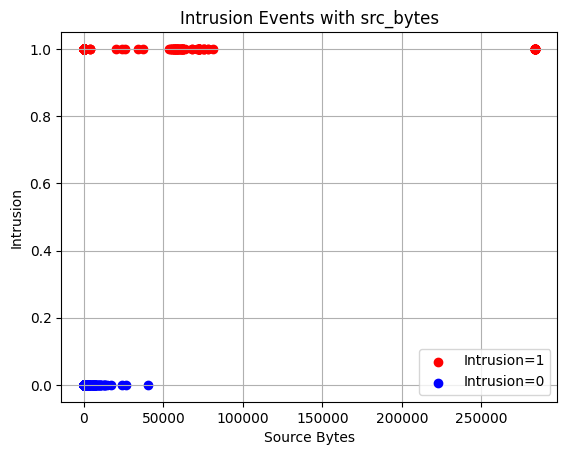

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the data into two DataFrames based on is_intrusion
intrusion_df = df[df['is_intrusion'] == 1]
non_intrusion_df = df[df['is_intrusion'] == 0]

# Create a scatter plot
plt.scatter(intrusion_df['src_bytes'], intrusion_df['is_intrusion'], color='red', label='Intrusion=1', marker='o')
plt.scatter(non_intrusion_df['src_bytes'], non_intrusion_df['is_intrusion'], color='blue', label='Intrusion=0', marker='o')

plt.xlabel('Source Bytes')
plt.ylabel('Intrusion')
plt.title('Intrusion Events with src_bytes')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

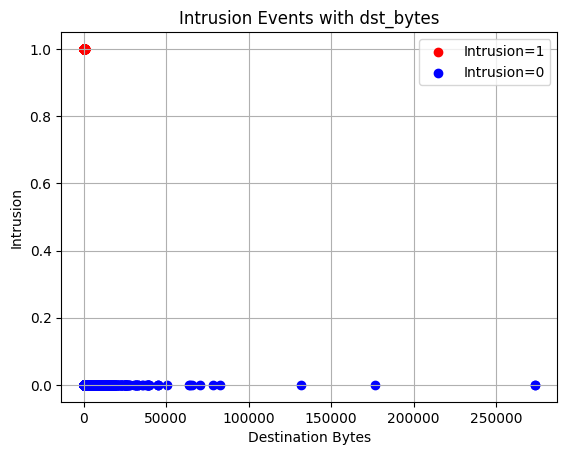

In [34]:

# Create a scatter plot
plt.scatter(intrusion_df['dst_bytes'], intrusion_df['is_intrusion'], color='red', label='Intrusion=1', marker='o')
plt.scatter(non_intrusion_df['dst_bytes'], non_intrusion_df['is_intrusion'], color='blue', label='Intrusion=0', marker='o')

plt.xlabel('Destination Bytes')
plt.ylabel('Intrusion')
plt.title('Intrusion Events with dst_bytes')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

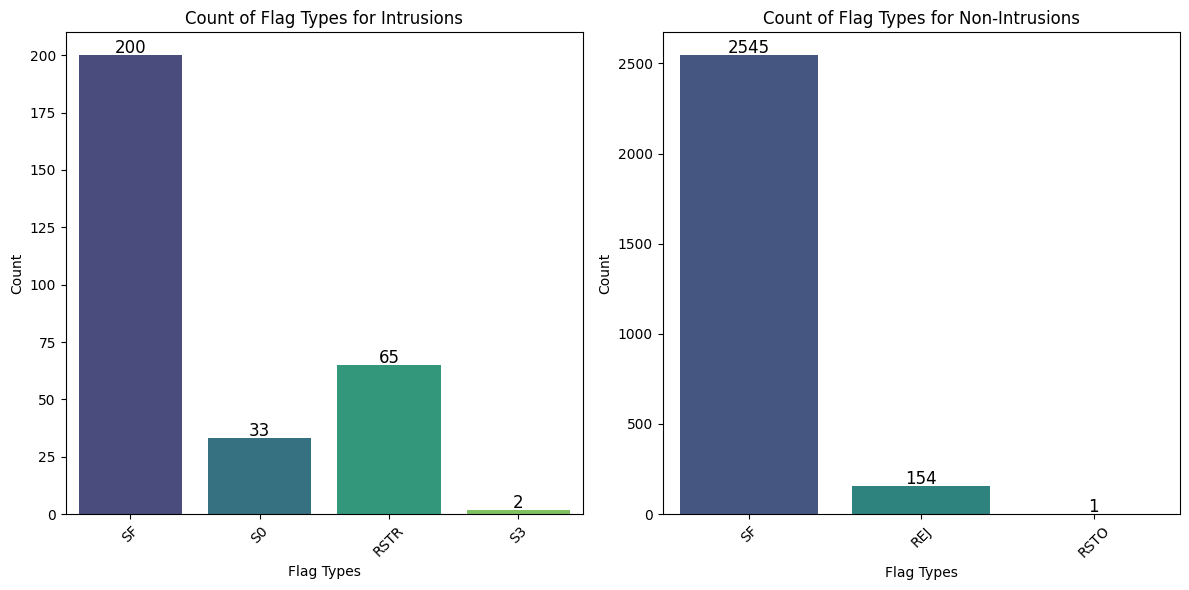

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create two DataFrames for intrusions and non-intrusions
intrusion_df = df[df['is_intrusion'] == 1]
non_intrusion_df = df[df['is_intrusion'] == 0]

# Create count plots for 'flag' in both categories
plt.figure(figsize=(12, 6))

# Count plot for intrusions
plt.subplot(1, 2, 1)
sns.countplot(data=intrusion_df, x='flag', palette='viridis')
plt.xlabel('Flag Types')
plt.ylabel('Count')
plt.title('Count of Flag Types for Intrusions')
plt.xticks(rotation=45)
ax1 = plt.gca()
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Count plot for non-intrusions
plt.subplot(1, 2, 2)
sns.countplot(data=non_intrusion_df, x='flag', palette='viridis')
plt.xlabel('Flag Types')
plt.ylabel('Count')
plt.title('Count of Flag Types for Non-Intrusions')
plt.xticks(rotation=45)
ax2 = plt.gca()
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()


# Model building

In [36]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='Your specific warning message')

import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pandas_profiling import ProfileReport

In [37]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('cleaned.csv')


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            3000 non-null   float64
 1   protocol_type       3000 non-null   object 
 2   service             3000 non-null   object 
 3   flag                3000 non-null   object 
 4   src_bytes           3000 non-null   float64
 5   dst_bytes           3000 non-null   float64
 6   hot                 3000 non-null   float64
 7   logged_in           3000 non-null   float64
 8   num_compromised     3000 non-null   float64
 9   root_shell          3000 non-null   float64
 10  su_attempted        3000 non-null   float64
 11  num_root            3000 non-null   float64
 12  num_file_creations  3000 non-null   float64
 13  num_shells          3000 non-null   float64
 14  num_access_files    3000 non-null   float64
 15  is_host_login       3000 non-null   float64
 16  is_gue

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Define evaluation metrics
scoring = {
    'F1': make_scorer(f1_score),
    'ROC AUC': make_scorer(roc_auc_score)
}

# Create models
model_rf = RandomForestClassifier(random_state=42)
model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

# Create a list of models for evaluation
models = [
    ('Random Forest', model_rf),
    ('XGBoost', model_xgb),
    ('Logistic Regression', model_lr)
]

# Evaluate models using cross-validation with multiple metrics
results = {}
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    results[name] = scores

# Display evaluation results
for name, scores in results.items():
    print(f"{name} - F1 Score: {scores['test_F1'].mean():.4f}, ROC AUC: {scores['test_ROC AUC'].mean():.4f}")


Random Forest - F1 Score: 0.8549, ROC AUC: 0.9457
XGBoost - F1 Score: 0.8552, ROC AUC: 0.9515
Logistic Regression - F1 Score: 0.4330, ROC AUC: 0.6472


# hyper parameter tuning 

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Create RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("F1 Score on Test Set:", f1)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}
F1 Score on Test Set: 0.8739495798319328


testing the code with updtated parameters :

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Define evaluation metric
scoring = make_scorer(f1_score)

# Create models with best hyperparameters
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'class_weight': 'balanced',
    'random_state': 42
}
model_rf = RandomForestClassifier(**best_rf_params)

model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

# Create a list of models for evaluation
models = [
    ('Random Forest', model_rf),
    ('XGBoost', model_xgb),
    ('Logistic Regression', model_lr)
]

# Evaluate models using cross-validation with F1 Score
results = {}
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results[name] = scores

# Display evaluation results
for name, scores in results.items():
    print(f"{name} - F1 Score: {scores.mean():.4f}")

Random Forest - F1 Score: 0.8802
XGBoost - F1 Score: 0.8552
Logistic Regression - F1 Score: 0.4330


# pca analysis

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
from sklearn.decomposition import PCA

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Fit a PCA model to the data
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate explained variance of PC1 and PC2
explained_variance_pc1 = pca.explained_variance_ratio_[0]
explained_variance_pc2 = pca.explained_variance_ratio_[1]

# Choose the best PCA configuration based on explained variance
if explained_variance_pc1 > explained_variance_pc2:
    n_components = 1  # Use only PC1
else:
    n_components = 2  # Use both PC1 and PC2

# Transform the dataset using the selected PCA configuration
pca = PCA(n_components=n_components)
X_transformed = pca.fit_transform(X)

# Create models with best hyperparameters
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'class_weight': 'balanced',
    'random_state': 42
}
model_rf = RandomForestClassifier(**best_rf_params)

model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

# Create a list of models for evaluation
models = [
    ('Random Forest', model_rf),
    ('XGBoost', model_xgb),
    ('Logistic Regression', model_lr)
]

# Evaluate models using cross-validation with F1 Score on transformed data
results = {}
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_transformed, y, cv=kfold, scoring='f1')
    results[name] = scores

# Display evaluation results
for name, scores in results.items():
    print(f"{name} - F1 Score: {scores.mean():.4f}")

Random Forest - F1 Score: 0.6956
XGBoost - F1 Score: 0.6914
Logistic Regression - F1 Score: 0.4545


code with the reults from pca

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
from sklearn.decomposition import PCA

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Fit a PCA model to the data
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate explained variance of PC1 and PC2
explained_variance_pc1 = pca.explained_variance_ratio_[0]
explained_variance_pc2 = pca.explained_variance_ratio_[1]

# Choose the best PCA configuration based on explained variance
if explained_variance_pc1 > explained_variance_pc2:
    n_components = 1  # Use only PC1
else:
    n_components = 2  # Use both PC1 and PC2

# Transform the dataset using the selected PCA configuration
pca = PCA(n_components=n_components)
X_transformed = pca.fit_transform(X)

# Create models with best hyperparameters
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'class_weight': 'balanced',
    'random_state': 42
}
model_rf = RandomForestClassifier(**best_rf_params)

model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

# Create a list of models for evaluation
models = [
    ('Random Forest', model_rf),
    ('XGBoost', model_xgb),
    ('Logistic Regression', model_lr)
]

# Evaluate models using cross-validation with F1 Score on transformed data
results = {}
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_transformed, y, cv=kfold, scoring='f1')
    results[name] = scores

# Display evaluation results
for name, scores in results.items():
    print(f"{name} - F1 Score: {scores.mean():.4f}")

Random Forest - F1 Score: 0.6956
XGBoost - F1 Score: 0.6914
Logistic Regression - F1 Score: 0.4545


In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Create a list of models for evaluation (Random Forest, XGBoost, Logistic Regression)
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
]

# Wrapper Method: Forward Selection using mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=100, random_state=42),
                                             k_features='best',
                                             forward=True,
                                             scoring='f1',
                                             cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
feature_selector.fit(X, y)
wrapper_selected_features = list(X.columns[list(feature_selector.k_feature_idx_)])

# Filter Method: SelectKBest with F-statistic
selector = SelectKBest(score_func=f_classif, k='all')
X_filtered = selector.fit_transform(X, y)
filter_selected_features = list(X.columns[selector.get_support()])

# Embedded Method: Lasso Regression for feature selection
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X, y)
lasso_coef = np.abs(lasso.coef_)
embedded_selected_features = list(X.columns[lasso_coef > 0])

# Combine selected features from all methods
all_selected_features = list(set(wrapper_selected_features + filter_selected_features + embedded_selected_features))

# Evaluate models using cross-validation with the selected features
results = {}
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X[all_selected_features], y, cv=kfold, scoring='f1')
    results[name] = scores

# Display evaluation results for models with selected features
for name, scores in results.items():
    print(f"{name} - F1 Score (Selected Features): {scores.mean():.4f}")

Random Forest - F1 Score (Selected Features): 0.8549
XGBoost - F1 Score (Selected Features): 0.8552
Logistic Regression - F1 Score (Selected Features): 0.4369


In [45]:
# Print the selected features
print("Selected Features:")
for feature in all_selected_features:
    print(feature)


Selected Features:
is_guest_login
num_file_creations
src_bytes
service
num_compromised
root_shell
logged_in
protocol_type
num_shells
hot
is_host_login
dst_bytes
flag
num_root
duration
su_attempted
num_access_files


Accuracy: 0.9733
Precision: 0.7647
Recall: 1.0000
F1-Score: 0.8667
ROC AUC: 0.9970
Confusion Matrix:
[[532  16]
 [  0  52]]


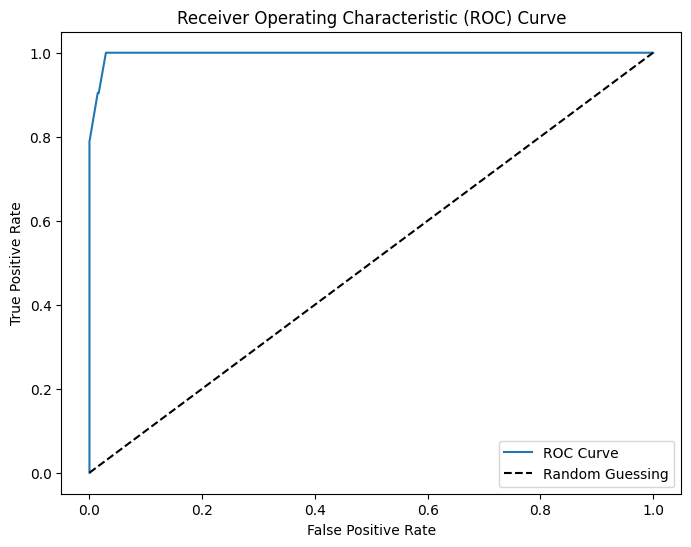

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Perform one-hot encoding for categorical columns
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

# Now, all categorical columns are converted into numeric format

# Split the data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Split the data into training and testing sets (adjust the test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost classifier (you can adjust hyperparameters)
classifier = XGBClassifier(random_state=42)

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Define evaluation metrics
scoring = {
    'F1 Score': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score)
}

# Create models with best hyperparameters
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'class_weight': 'balanced',
    'random_state': 42
}
model_rf = RandomForestClassifier(**best_rf_params)

model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

# Create a list of models for evaluation
models = [
    ('Random Forest', model_rf),
    ('XGBoost', model_xgb),
    ('Logistic Regression', model_lr)
]

# Evaluate models using cross-validation with multiple metrics
results = {}
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    results[name] = scores

# Display evaluation results
for name, scores in results.items():
    print(f"{name} - F1 Score: {scores['test_F1 Score'].mean():.4f}")
    print(f"{name} - Precision: {scores['test_Precision'].mean():.4f}")
    print(f"{name} - Recall: {scores['test_Recall'].mean():.4f}")
    print(f"{name} - Accuracy: {scores['test_Accuracy'].mean():.4f}")


Random Forest - F1 Score: 0.8802
Random Forest - Precision: 0.7953
Random Forest - Recall: 0.9867
Random Forest - Accuracy: 0.9730
XGBoost - F1 Score: 0.8552
XGBoost - Precision: 0.7991
XGBoost - Recall: 0.9300
XGBoost - Accuracy: 0.9687
Logistic Regression - F1 Score: 0.4330
Logistic Regression - Precision: 0.8244
Logistic Regression - Recall: 0.3033
Logistic Regression - Accuracy: 0.9223


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Load your dataset into a DataFrame
df = pd.read_csv('cleaned.csv')

# Encode categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split data into features (X) and target (y)
X = df.drop('is_intrusion', axis=1)
y = df['is_intrusion']

# Define evaluation metrics
scoring = {
    'F1 Score': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'AUC': make_scorer(roc_auc_score)
}

# Create models with best hyperparameters
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'class_weight': 'balanced',
    'random_state': 42
}
model_rf = RandomForestClassifier(**best_rf_params)

model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42)

# Create a list of models for evaluation
models = [
    ('Random Forest', model_rf),
    ('XGBoost', model_xgb),
    ('Logistic Regression', model_lr)
]

# Initialize PrettyTable for tabulating results
table = PrettyTable()
table.field_names = ['Model', 'F1 Score', 'Precision', 'Recall', 'AUC']

# Initialize lists to store ROC-AUC data
roc_auc_data = []

# Evaluate models using cross-validation with multiple metrics
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    
    # Calculate mean scores for each metric and round to 2 decimal places
    f1_mean = round(scores['test_F1 Score'].mean(), 2)
    precision_mean = round(scores['test_Precision'].mean(), 2)
    recall_mean = round(scores['test_Recall'].mean(), 2)
    auc_mean = round(scores['test_AUC'].mean(), 2)
    
    # Add results to the PrettyTable
    table.add_row([name, f1_mean, precision_mean, recall_mean, auc_mean])
    
    

# Print the table
print(table)


+---------------------+----------+-----------+--------+------+
|        Model        | F1 Score | Precision | Recall | AUC  |
+---------------------+----------+-----------+--------+------+
|    Random Forest    |   0.88   |    0.8    |  0.99  | 0.98 |
|       XGBoost       |   0.86   |    0.8    |  0.93  | 0.95 |
| Logistic Regression |   0.43   |    0.82   |  0.3   | 0.65 |
+---------------------+----------+-----------+--------+------+


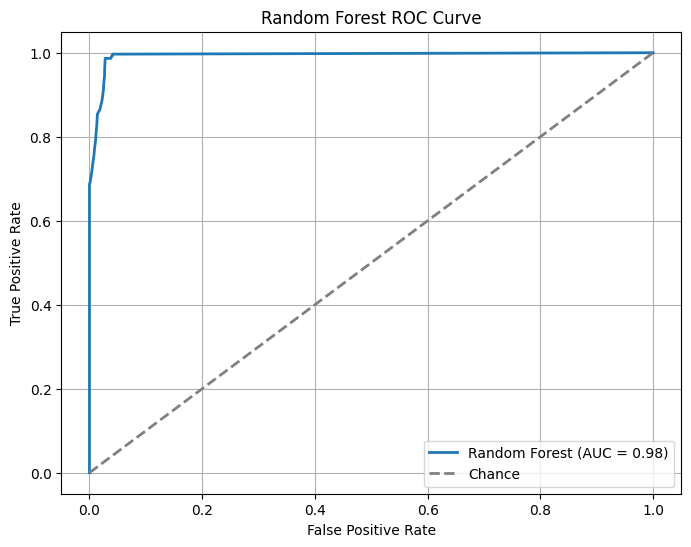

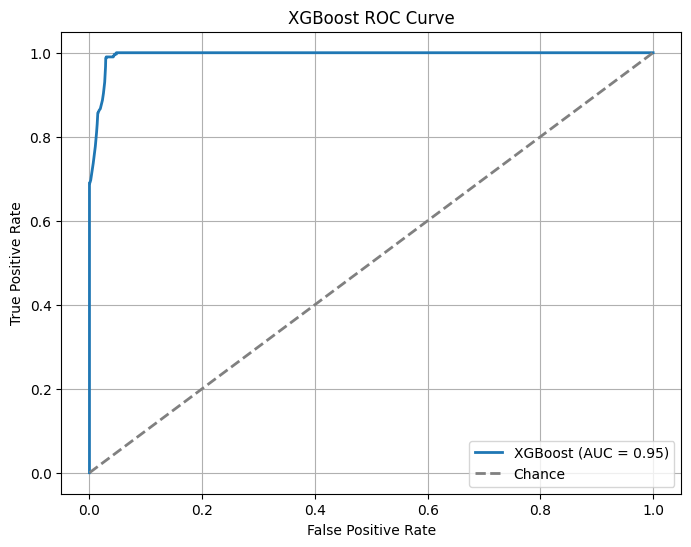

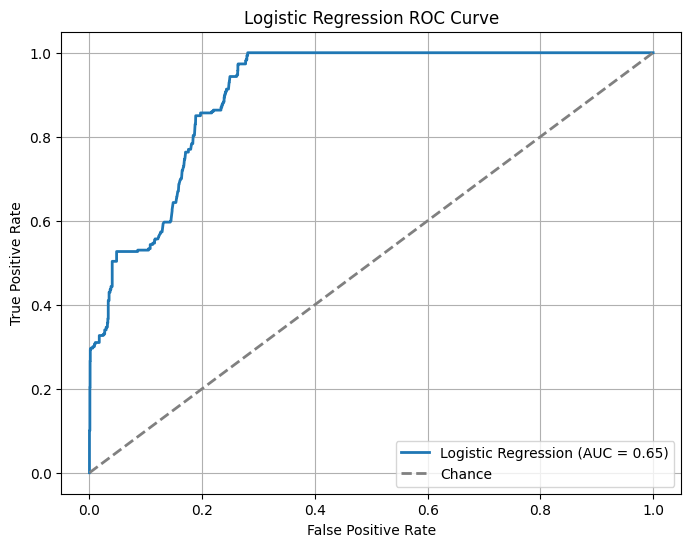

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot ROC curves
def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})', linewidth=2)
    
    # Plot the chance line (random classifier)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', linewidth=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Loop through models and plot ROC curves
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Calculate mean scores for each metric and round to 2 decimal places
    scores = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    auc_mean = round(scores['test_AUC'].mean(), 2)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y, cross_val_predict(model, X, y, cv=kfold, method='predict_proba')[:, 1])
    
    # Display the ROC curve in a separate cell
    plot_roc_curve(fpr, tpr, auc_mean, name)


In [50]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Update the best_rf_params dictionary with class weights
best_rf_params['class_weight'] = class_weights_dict

# Create the RandomForest model with updated parameters
model_rf = RandomForestClassifier(**best_rf_params)

# Update LogisticRegression with class weights
model_lr = LogisticRegression(random_state=42, class_weight=class_weights_dict)

# For XGBoost, calculate scale_pos_weight
scale_pos_weight = sum(y == 0) / sum(y == 1)
model_xgb = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)


In [51]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.is_intrusion == 0]
df_minority = df[df.is_intrusion == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Split upsampled dataset into features and target
X_upsampled = df_upsampled.drop('is_intrusion', axis=1)
y_upsampled = df_upsampled['is_intrusion']


In [52]:
# Initialize PrettyTable for tabulating results
table = PrettyTable()
table.field_names = ['Model', 'Dataset', 'F1 Score', 'Precision', 'Recall', 'AUC']

# Evaluate models on both original and upsampled data
datasets = {'Original': (X, y), 'Upsampled': (X_upsampled, y_upsampled)}

for dataset_name, (X_set, y_set) in datasets.items():
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        scores = cross_validate(model, X_set, y_set, cv=kfold, scoring=scoring)

        # Calculate mean scores for each metric and round to 2 decimal places
        f1_mean = round(scores['test_F1 Score'].mean(), 2)
        precision_mean = round(scores['test_Precision'].mean(), 2)
        recall_mean = round(scores['test_Recall'].mean(), 2)
        auc_mean = round(scores['test_AUC'].mean(), 2)
        
        # Add results to the PrettyTable
        table.add_row([name, dataset_name, f1_mean, precision_mean, recall_mean, auc_mean])

# Print the table
print(table)


+---------------------+-----------+----------+-----------+--------+------+
|        Model        |  Dataset  | F1 Score | Precision | Recall | AUC  |
+---------------------+-----------+----------+-----------+--------+------+
|    Random Forest    |  Original |   0.88   |    0.8    |  0.99  | 0.98 |
|       XGBoost       |  Original |   0.86   |    0.8    |  0.93  | 0.95 |
| Logistic Regression |  Original |   0.43   |    0.82   |  0.3   | 0.65 |
|    Random Forest    | Upsampled |   0.98   |    0.97   |  0.99  | 0.98 |
|       XGBoost       | Upsampled |   0.98   |    0.97   |  0.99  | 0.98 |
| Logistic Regression | Upsampled |   0.9    |    0.83   |  0.99  | 0.89 |
+---------------------+-----------+----------+-----------+--------+------+


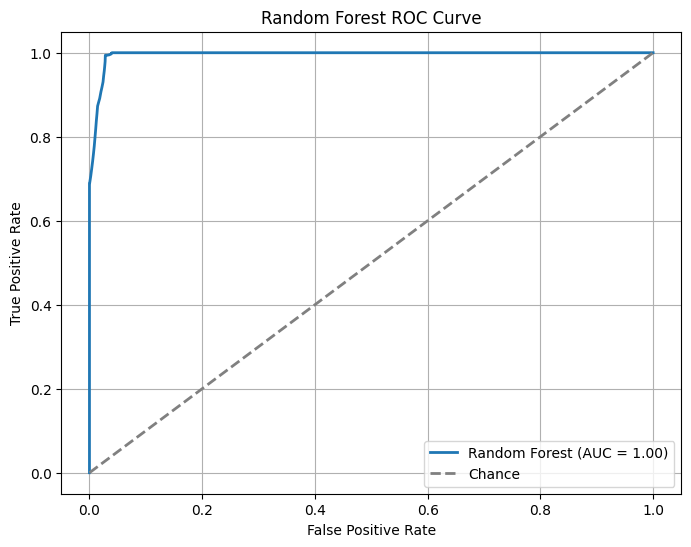

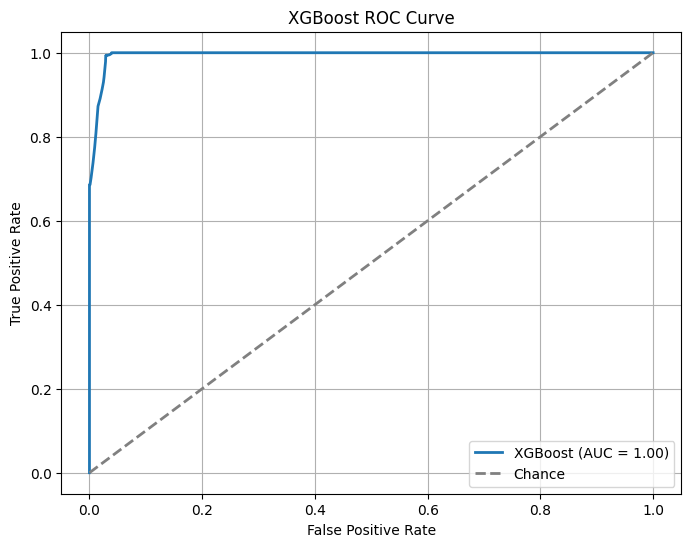

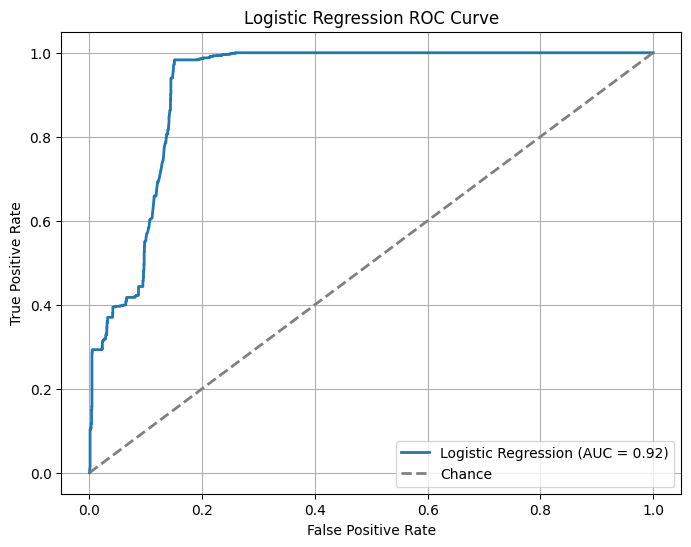

In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define a function to plot ROC curves
def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})', linewidth=2)
    
    # Plot the chance line (random classifier)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', linewidth=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Loop through models and plot ROC curves using upsampled data
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Calculate ROC curve using upsampled data
    y_probas = cross_val_predict(model, X_upsampled, y_upsampled, cv=kfold, method='predict_proba')
    fpr, tpr, _ = roc_curve(y_upsampled, y_probas[:, 1])
    auc_score = auc(fpr, tpr)
    
    # Display the ROC curve
    plot_roc_curve(fpr, tpr, auc_score, name)
